# Data Exploration

In [1]:
import string
import pandas as pd

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud 

In [2]:
data = pd.read_excel("../data/sentences_with_sentiment.xlsx", index_col="ID")
data.head()

,Sentence,Positive,Negative,Neutral
ID,,,,
1,The results in 2nd line treatment show an ORR ...,1,0,0
2,The long duration of response and high durable...,1,0,0
3,The median OS time in the updated results exce...,0,0,1
4,"Therefore, the clinical benefit in 2nd line tr...",1,0,0
5,"The data provided in 1st line, although prelim...",1,0,0


### 1. Data Validation

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 266 entries, 1 to 266
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sentence  266 non-null    object
 1   Positive  266 non-null    int64 
 2   Negative  266 non-null    int64 
 3   Neutral   266 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 10.4+ KB


In [4]:
data[["Positive", "Negative", "Neutral"]].sum() # instances per sentiment class

Positive    160
Negative     36
Neutral      70
dtype: int64

In [5]:
set(data[["Positive", "Negative", "Neutral"]].sum(axis=1)) # all labels are valid. No double entries.

{1}

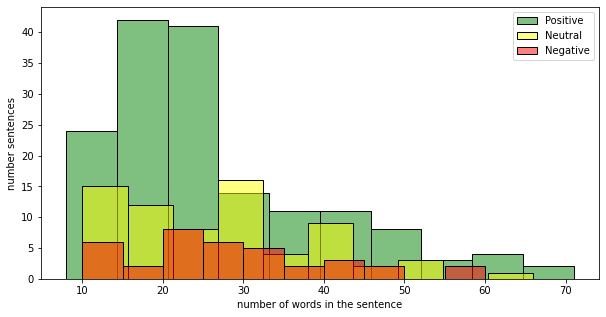

In [6]:
# Distribution of the sentence length

pos_length = [len(word_tokenize(sentence)) for sentence in data[data.Positive.values == 1].Sentence.values]
neutr_length = [len(word_tokenize(sentence)) for sentence in data[data.Neutral.values == 1].Sentence.values]
neg_length = [len(word_tokenize(sentence)) for sentence in data[data.Negative.values == 1].Sentence.values]

fig, ax = plt.subplots( figsize=(10,5))
ax = sns.histplot(pos_length, bins = 10, label="Positive", color="green", alpha=0.5)
ax = sns.histplot(neutr_length, bins = 10, label="Neutral", color="yellow", alpha=0.5)
ax = sns.histplot(neg_length, bins = 10, label="Negative", color="red", alpha=0.5)
ax.set_xlabel("number of words in the sentence")
ax.set_ylabel("number sentences")
ax.legend()

fig.savefig("../plots/distribution_sentencelength.jpg")

### 2. Data Preprocessing

In [7]:
target_mapping = {0: "Positive",
                  1: "Neutral",
                  2: "Negative"
                 }

# Add label column
def transform_label(row):
    if row.Positive == 1:
        return 0
    elif row.Neutral == 1:
        return 1
    elif row.Negative == 1:
        return 2
    
data["Label"] = data.apply(lambda row: transform_label(row), axis=1)
data.drop(["Positive", "Negative", "Neutral"], axis=1, inplace=True)

In [8]:
def preprocess_sentence(sentence, stemming=True):
    
    # lower case
    sentence = sentence.lower()
    
    # custom changes "/"/, "-"
    sentence = sentence.replace("/", " ")
    sentence = sentence.replace("-", " ")
        
    # remove punctuation, quotes
    sentence = "".join([char for char in sentence if char not in string.punctuation])
    sentence = sentence.replace("‘", "")
    sentence = sentence.replace("’", "")

    
    # tokenize
    tokens = nltk.word_tokenize(sentence)
    
    # remove all tokens with number
    #tokens = [elm for elm in tokens if not any(char.isdigit() for char in elm)]
    
    # remove all tokens with non-alphabetic numbers
    tokens = [item for item in tokens if item.isalpha()]
    
    #remove stop words
    stop_words = set(stopwords.words("english"))
    tokens = [i for i in tokens if not i in stop_words]
    
    if not stemming:
        prep_sentence = " ".join(tokens)
        return prep_sentence
    
    elif stemming:
        #stemming
        porter = PorterStemmer()
        stemmed = [porter.stem(word) for word in tokens]
        stemmed_sentence = " ".join(stemmed)

        return stemmed_sentence

In [9]:
# add columns
data["Prep_sentence"] = data.apply(lambda row: preprocess_sentence(row.Sentence, stemming=False), axis=1)
data["Stemmed_sentence"] = data.apply(lambda row: preprocess_sentence(row.Sentence, stemming=True), axis=1)

In [10]:
data.to_csv("../data/sentences_with_sentiment_preprocessed.csv")

### 3. Plot Data

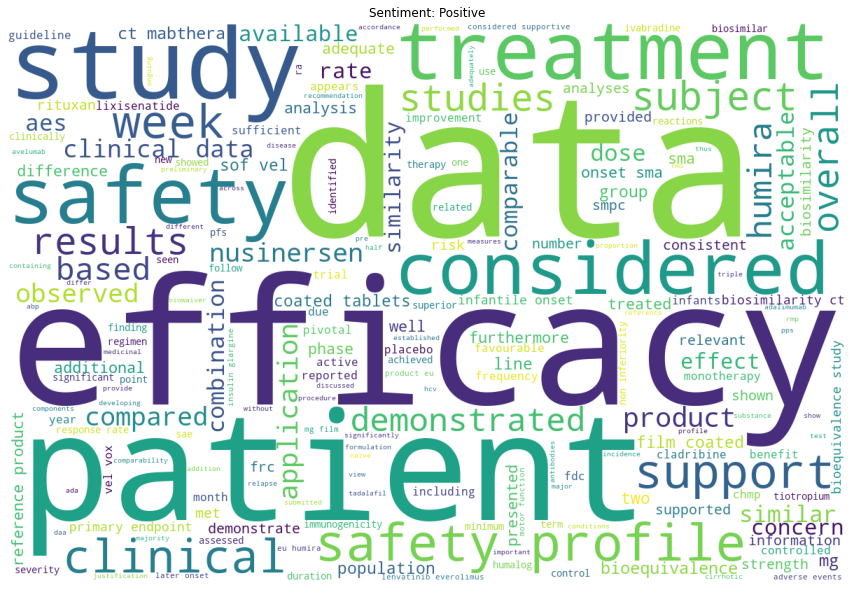

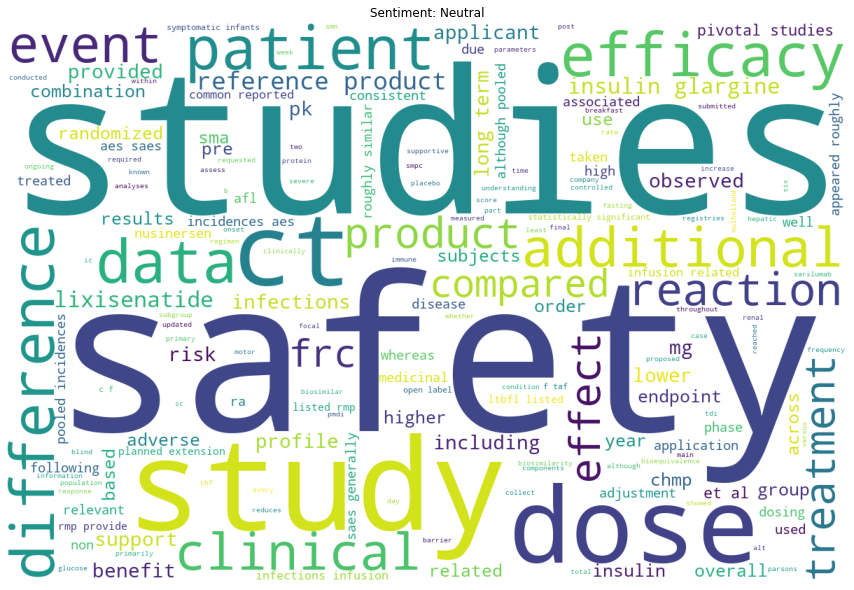

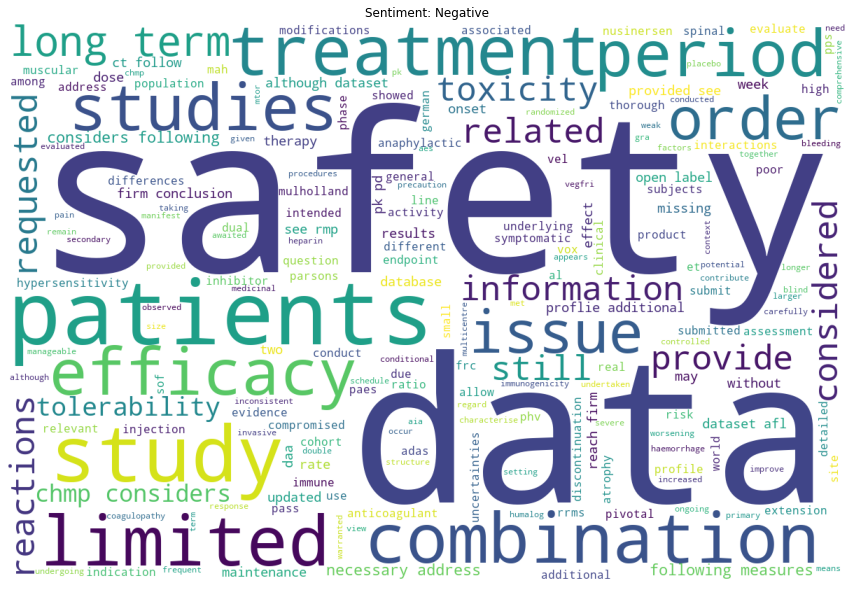

In [13]:
for label in range(3):

    wordcloud = WordCloud(width = 1200, height = 800, 
                background_color ='white', 
                min_font_size = 10).generate(' '.join(data[data.Label == label].Prep_sentence.values)) 

    plt.figure(figsize = (12, 8)) 
    plt.imshow(wordcloud) 
    plt.axis("off")
    plt.title("Sentiment: {}".format(target_mapping[label]))
    plt.tight_layout(pad = 0)
    plt.savefig("../plots/word_cloud_{}.jpg".format(label))
    plt.show()